In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

In [2]:
def read_data(file_dir, fname, i):
    
    fname_tmp = file_dir + "{:04}".format(i) + fname
    data = np.load(fname_tmp)
    
    return data

In [5]:
file_dir='/Users/zoeatoy/Downloads/public_training_data/'
fname_gt ='_IVIMParam.npy'
fname_gtDWI ='_gtDWIs.npy'
fname_tissue ='_TissueType.npy'
fname_noisyDWIk = '_NoisyDWIk.npy'

#Nx = 200
#Ny = 200
b = np.array([0, 5, 50, 100, 200, 500, 800, 1000])

random_image_number = 42
# load gt data
params = read_data(file_dir, fname_gt, random_image_number)
clean = read_data(file_dir, fname_gtDWI, random_image_number)
# load noisy data and perform baseline reconstruction
k= read_data(file_dir, fname_noisyDWIk, random_image_number)
# load tissue type data
tissue = read_data(file_dir, fname_tissue, random_image_number)

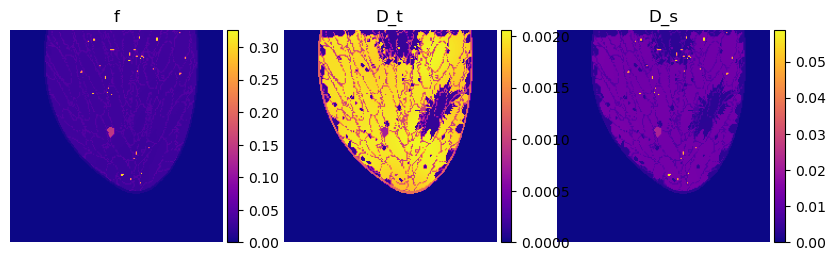

In [6]:
titles = ['f', 'D_t', 'D_s']
fig, ax = plt.subplots(1,3, figsize=(10,55))
for i in range(3):
    im = ax[i].imshow(params[:,:,i], cmap='plasma')
    ax[i].axis('off')
    ax[i].set_title(f'{titles[i]}')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

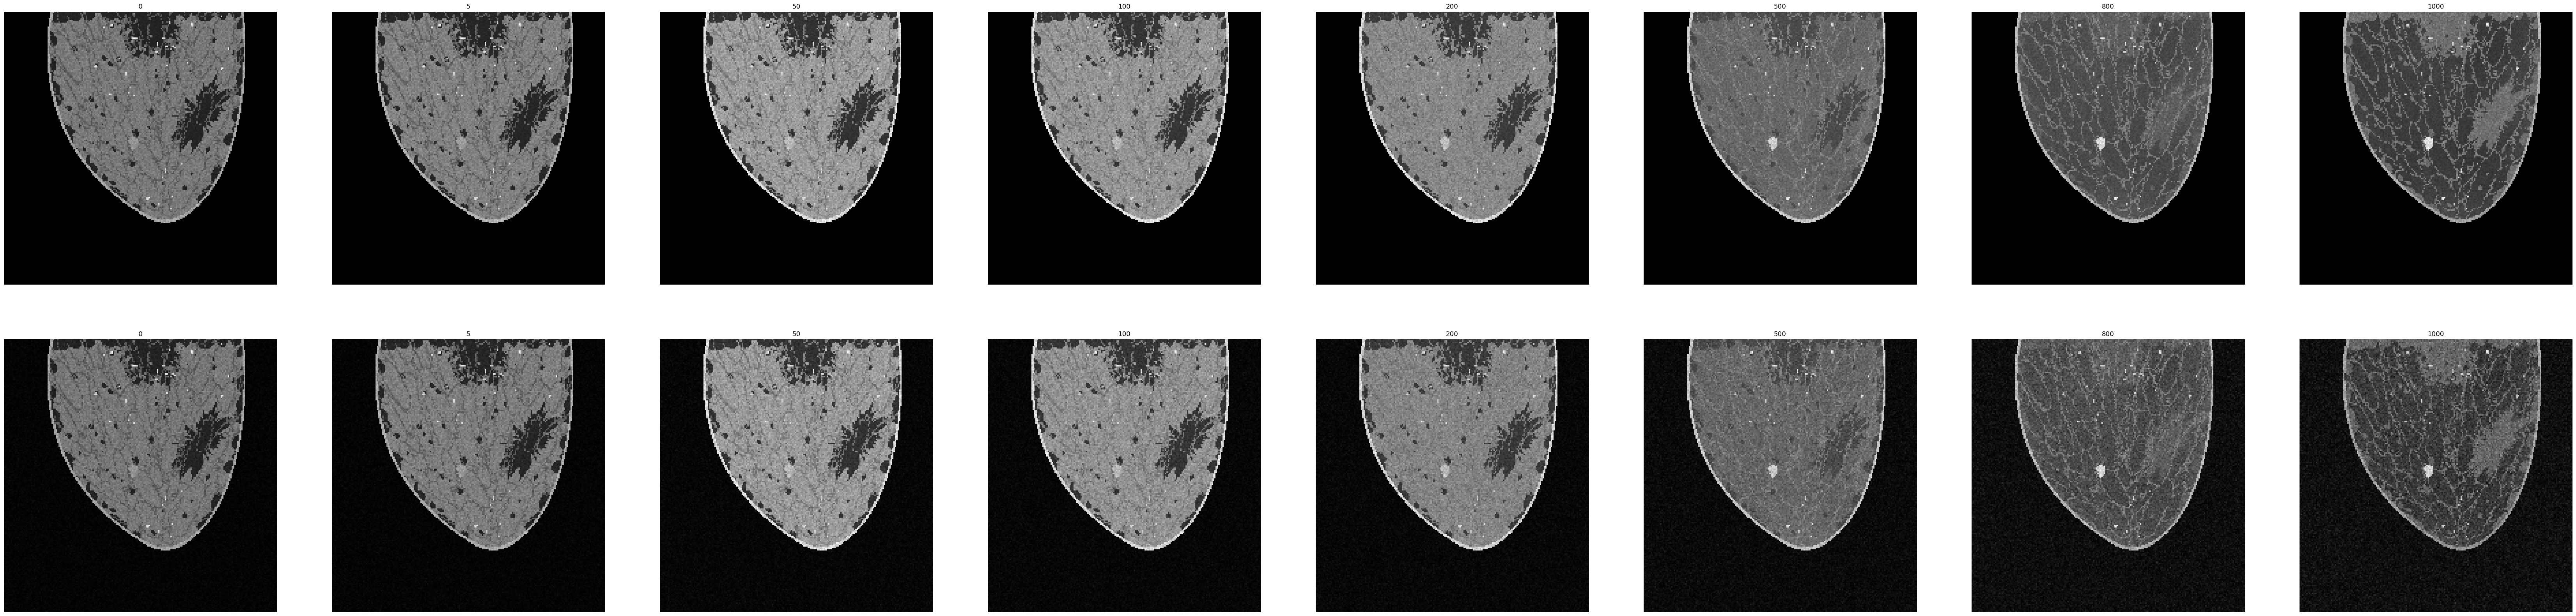

In [7]:
fig, ax = plt.subplots(2,8, figsize=(85,20))
for i in range(8):
    im = ax[0, i].imshow(np.abs(clean[:,:,i]), cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title(f'{b[i]}')
    im = ax[1, i].imshow(np.abs(np.fft.ifft2(k[:,:,i], axes=(0,1) ,norm='ortho')), cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title(f'{b[i]}')

In [8]:
from tqdm import tqdm
pure_noise_re = {i:[] for i in range(8)}
pure_noise_im = {i:[] for i in range(8)}

for image_number in tqdm(range(1, 101)):
    # load gt data
    params = read_data(file_dir, fname_gt, image_number)
    clean = read_data(file_dir, fname_gtDWI, image_number)
    # load noisy data and perform baseline reconstruction
    k = read_data(file_dir, fname_noisyDWIk, image_number)
    # load tissue type data
    tissue = read_data(file_dir, fname_tissue, image_number)

    for b_value in range(8):

        clean_real = np.real(clean[:, :, b_value])
        noisy_real = np.real(np.fft.ifft2(k[:,:,b_value], axes=(0,1) ,norm='ortho'))
        coordBody = np.argwhere(tissue==8)
        pure_noise_re[b_value].append(noisy_real[coordBody[:,0], coordBody[:,1]] - clean_real[coordBody[:,0], coordBody[:,1]])

    for b_value in range(8):

        clean_img = np.imag(clean[:, :, b_value])
        noisy_img = np.imag(np.fft.ifft2(k[:,:,b_value], axes=(0,1) ,norm='ortho'))
        coordBody = np.argwhere(tissue==8)
        pure_noise_im[b_value].append(noisy_img[coordBody[:,0], coordBody[:,1]]- clean_img[coordBody[:,0], coordBody[:,1]])

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 74.38it/s]


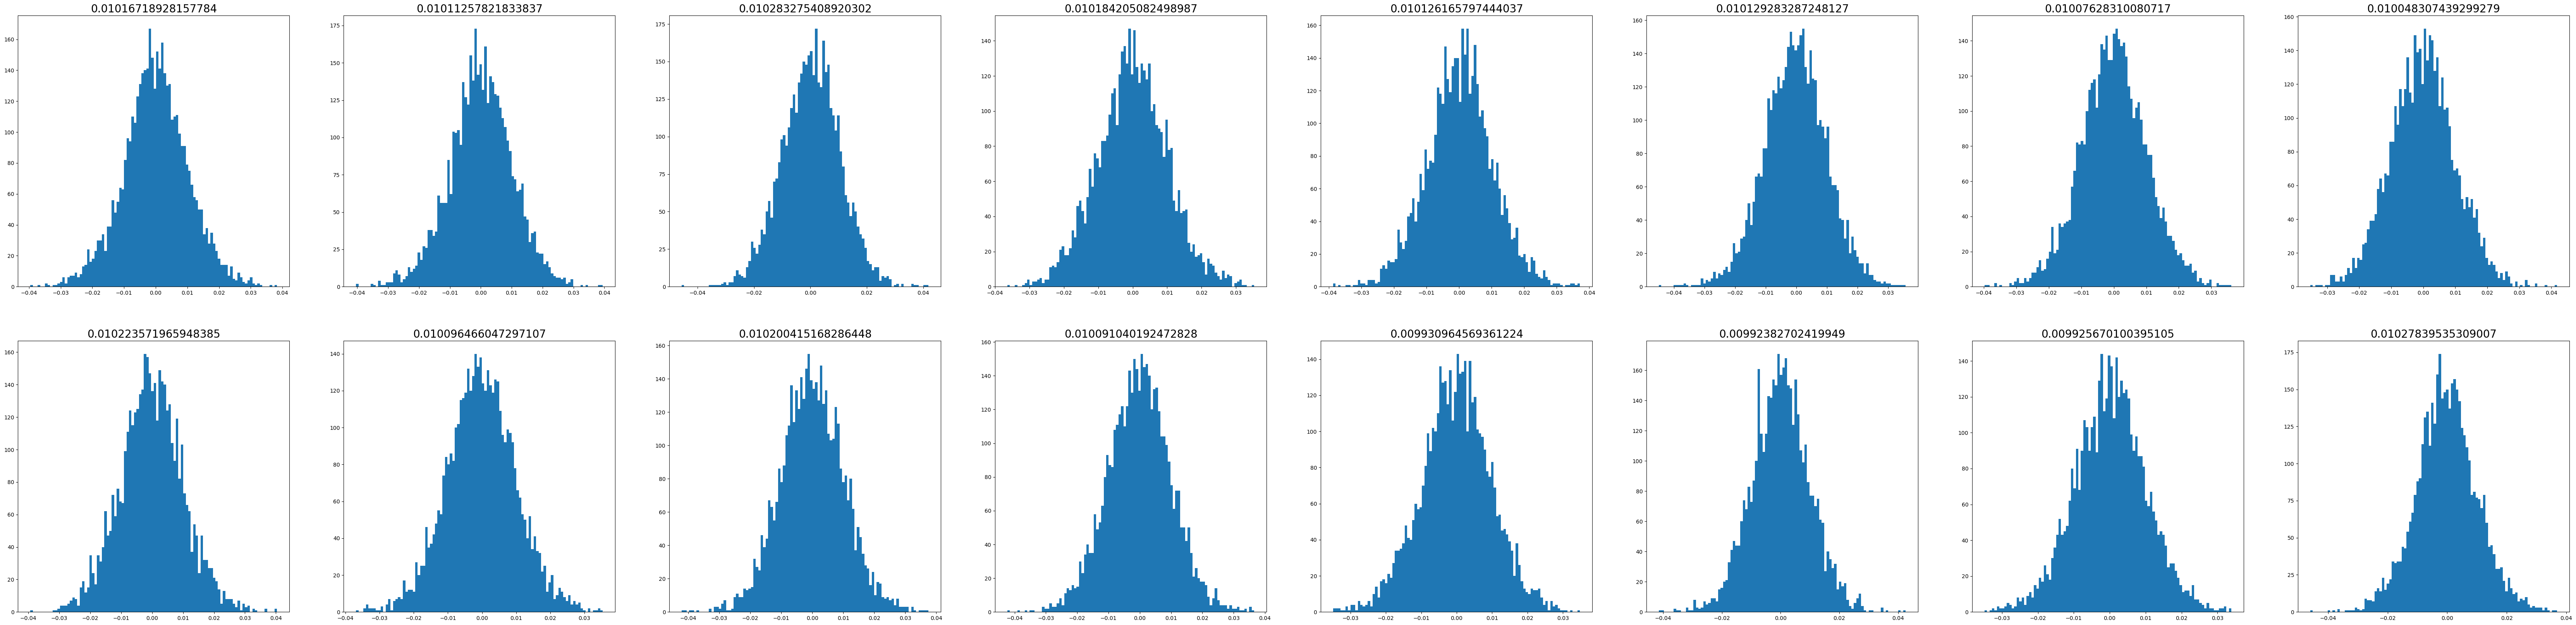

In [9]:
fig, ax = plt.subplots(2,8, figsize=(85,20))
for b_value in range(8):
    pure_noise_re[b_value] = np.concatenate(pure_noise_re[b_value]).ravel()
    ax[0, b_value].hist(pure_noise_re[b_value], bins=100)
    ax[0, b_value].set_title(np.std(np.asarray(pure_noise_re[b_value])), fontsize=20)

    pure_noise_im[b_value] = np.concatenate(pure_noise_im[b_value]).ravel()
    ax[1, b_value].hist(pure_noise_im[b_value], bins=100)
    ax[1, b_value].set_title(np.std(np.asarray(pure_noise_im[b_value])), fontsize=20)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 157.84it/s]


Text(0.5, 1.0, 'D_star')

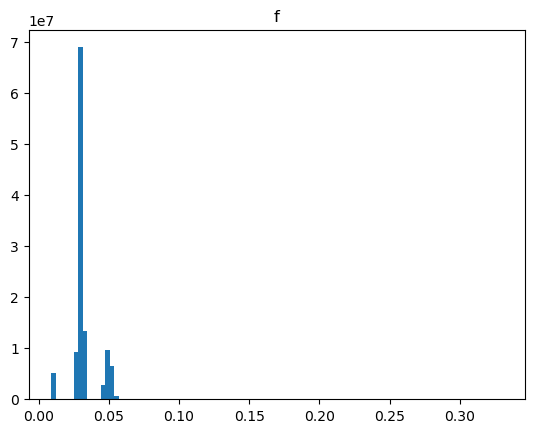

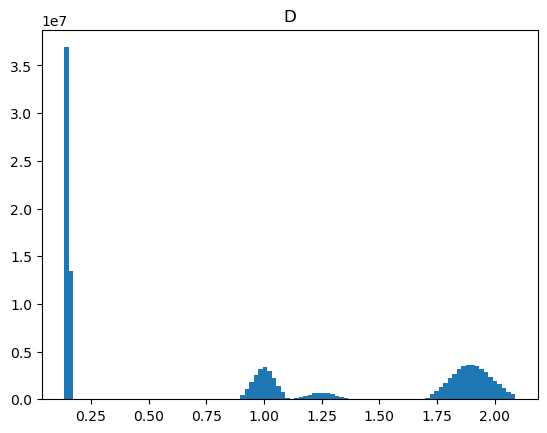

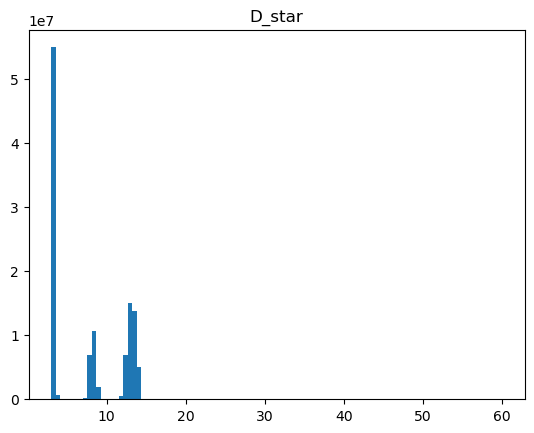

In [10]:
from tqdm import tqdm
f = []
D = []
D_star = []
for image_number in tqdm(range(1, 1001)):
    # load gt data
    params = read_data(file_dir, fname_gt, image_number)
    clean = read_data(file_dir, fname_gtDWI, image_number)
    f_measurement = params[:, :, 0]
    D_measurement = params[:, :, 1]
    D_star_measurement = params[:, :, 2]
    coordBody = np.argwhere(clean > 0)
    f.append(f_measurement[coordBody[:,0], coordBody[:,1]])
    D.append(1000*D_measurement[coordBody[:,0], coordBody[:,1]])
    D_star.append(1000*D_star_measurement[coordBody[:,0], coordBody[:,1]])


f = np.concatenate(f).ravel()
a = plt.hist(f, bins=100)
plt.title('f')

plt.figure()
D = np.concatenate(D).ravel()
a = plt.hist(D, bins=100)
plt.title('D')

plt.figure()
D_star = np.concatenate(D_star).ravel()
a = plt.hist(D_star, bins=100)
plt.title('D_star')

In [13]:
import numpy as np
from tqdm import tqdm

f = []
D = []
D_star = []

for image_number in tqdm(range(1, 1001)):
    # load gt data
    params = read_data(file_dir, fname_gt, image_number)
    clean = read_data(file_dir, fname_gtDWI, image_number)
    f_measurement = params[:, :, 0]
    D_measurement = params[:, :, 1]
    D_star_measurement = params[:, :, 2]
    coordBody = np.argwhere(clean > 0)

    f.append(f_measurement[coordBody[:, 0], coordBody[:, 1]])
    D.append(1000 * D_measurement[coordBody[:, 0], coordBody[:, 1]])        # scale D
    D_star.append(1000 * D_star_measurement[coordBody[:, 0], coordBody[:, 1]])  # scale D*

#flatten arrays
f = np.concatenate(f).ravel()
D = np.concatenate(D).ravel()
D_star = np.concatenate(D_star).ravel()

#function to summarize histogram
def summarize_distribution(data, name, bins=100):
    print(f"\nSummary statistics for {name}:")
    print(f"  Count: {len(data):,}")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std Dev: {np.std(data):.4f}")
    print(f"  Min: {np.min(data):.4f}")
    print(f"  Max: {np.max(data):.4f}")
    print(f"  25th / Median / 75th percentiles: "
          f"{np.percentile(data, 25):.4f} / {np.median(data):.4f} / {np.percentile(data, 75):.4f}")

    # Optional: print a condensed histogram (10 bins for readability)
    counts, bin_edges = np.histogram(data, bins=10)
    print(f"\n  Histogram (10 bins):")
    for i in range(len(counts)):
        print(f"    {bin_edges[i]:.3f} – {bin_edges[i+1]:.3f}: {counts[i]:,}")

#frint summaries
summarize_distribution(f, "f")
summarize_distribution(D, "D (x1000)")
summarize_distribution(D_star, "D* (x1000)")


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 159.77it/s]



Summary statistics for f:
  Count: 117,262,363
  Mean: 0.0341
  Std Dev: 0.0215
  Min: 0.0090
  Max: 0.3300
  25th / Median / 75th percentiles: 0.0291 / 0.0303 / 0.0318

  Histogram (10 bins):
    0.009 – 0.041: 96,725,170
    0.041 – 0.073: 19,644,370
    0.073 – 0.105: 0
    0.105 – 0.137: 8,548
    0.137 – 0.170: 320,747
    0.170 – 0.202: 0
    0.202 – 0.234: 0
    0.234 – 0.266: 0
    0.266 – 0.298: 238,454
    0.298 – 0.330: 325,074

Summary statistics for D (x1000):
  Count: 117,262,363
  Mean: 0.9613
  Std Dev: 0.7740
  Min: 0.1350
  Max: 2.0900
  25th / Median / 75th percentiles: 0.1517 / 0.9875 / 1.8505

  Histogram (10 bins):
    0.135 – 0.331: 50,387,607
    0.331 – 0.526: 0
    0.526 – 0.722: 222
    0.722 – 0.917: 825,267
    0.917 – 1.113: 19,711,704
    1.113 – 1.308: 4,370,254
    1.308 – 1.504: 786,699
    1.504 – 1.699: 0
    1.699 – 1.895: 19,777,259
    1.895 – 2.090: 21,403,351

Summary statistics for D* (x1000):
  Count: 117,262,363
  Mean: 7.9042
  Std Dev: 5.5

In [15]:
import numpy as np
import pandas as pd

def summarize_distribution_pd(data, name, bins=10):
    summary = {
        "Metric": ["Count", "Mean", "Std Dev", "Min", "25th Percentile", "Median", "75th Percentile", "Max"],
        name: [
            f"{len(data):,}",
            round(np.mean(data), 4),
            round(np.std(data), 4),
            round(np.min(data), 4),
            round(np.percentile(data, 25), 4),
            round(np.median(data), 4),
            round(np.percentile(data, 75), 4),
            round(np.max(data), 4)
        ]
    }

    df_summary = pd.DataFrame(summary)

    # Histogram
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_labels = [f"{round(bin_edges[i], 3)} – {round(bin_edges[i+1], 3)}" for i in range(bins)]
    df_hist = pd.DataFrame({
        "Range": bin_labels,
        "Count": counts
    })

    return df_summary, df_hist

# Example usage:
df_f_summary, df_f_hist = summarize_distribution_pd(f, "f")
df_D_summary, df_D_hist = summarize_distribution_pd(D, "D (x1000)")
df_D_star_summary, df_D_star_hist = summarize_distribution_pd(D_star, "D* (x1000)")

# To export to clipboard and paste into Word/Excel:
# df_f_summary.to_clipboard(index=False)
# df_f_hist.to_clipboard(index=False)

In [17]:
df_f_summary

,Metric,f
0,Count,"117,262,363"
1,Mean,0.0341
2,Std Dev,0.0215
3,Min,0.009
4,25th Percentile,0.0291
5,Median,0.0303
6,75th Percentile,0.0318
7,Max,0.33


In [16]:
df_f_hist

,Range,Count
0,0.009 – 0.041,96725170
1,0.041 – 0.073,19644370
2,0.073 – 0.105,0
3,0.105 – 0.137,8548
4,0.137 – 0.17,320747
5,0.17 – 0.202,0
6,0.202 – 0.234,0
7,0.234 – 0.266,0
8,0.266 – 0.298,238454
9,0.298 – 0.33,325074


In [18]:
df_D_summary

,Metric,D (x1000)
0,Count,"117,262,363"
1,Mean,0.9613
2,Std Dev,0.774
3,Min,0.135
4,25th Percentile,0.1517
5,Median,0.9875
6,75th Percentile,1.8505
7,Max,2.09


In [19]:
df_D_hist

,Range,Count
0,0.135 – 0.33,50387607
1,0.33 – 0.526,0
2,0.526 – 0.722,222
3,0.722 – 0.917,825267
4,0.917 – 1.113,19711704
5,1.113 – 1.308,4370254
6,1.308 – 1.504,786699
7,1.504 – 1.699,0
8,1.699 – 1.895,19777259
9,1.895 – 2.09,21403351


In [20]:
df_D_star_summary

,Metric,D* (x1000)
0,Count,"117,262,363"
1,Mean,7.9042
2,Std Dev,5.5951
3,Min,3.0
4,25th Percentile,3.3023
5,Median,7.9061
6,75th Percentile,12.9216
7,Max,60.0


In [21]:
df_D_star_summary

,Metric,D* (x1000)
0,Count,"117,262,363"
1,Mean,7.9042
2,Std Dev,5.5951
3,Min,3.0
4,25th Percentile,3.3023
5,Median,7.9061
6,75th Percentile,12.9216
7,Max,60.0


In [11]:
def s(x):
    return 1/(1+np.exp(-x))

s(-3)

0.04742587317756678

In [25]:
import numpy as np
import pandas as pd

# Only non-zero b-values to avoid constant signal
bvals = np.array([50, 200, 400, 800])

n_voxels = 10
np.random.seed(42)
f = np.random.uniform(0.02, 0.06, size=n_voxels)
D = np.random.uniform(0.5, 1.5, size=n_voxels)
D_star = np.random.uniform(5, 15, size=n_voxels)

S0 = 1000
signals = []

for i in range(n_voxels):
    si = S0 * (f[i] * np.exp(-bvals * D_star[i]) + (1 - f[i]) * np.exp(-bvals * D[i]))
    signals.append(si)

signals = np.array(signals)  # shape: (10, 4)

def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return np.nan
    return np.corrcoef(x, y)[0, 1]

correlations = {'b-value': bvals, 'corr_f': [], 'corr_D': [], 'corr_D_star': []}

for i in range(signals.shape[1]):
    s = signals[:, i]
    correlations['corr_f'].append(safe_corr(s, f))
    correlations['corr_D'].append(safe_corr(s, D))
    correlations['corr_D_star'].append(safe_corr(s, D_star))

df_corr = pd.DataFrame(correlations)
print(df_corr)


   b-value    corr_f    corr_D  corr_D_star
0       50 -0.162214 -0.435593     0.317934
1      200 -0.161959 -0.435394     0.317718
2      400 -0.161959 -0.435394     0.317718
3      800       NaN       NaN          NaN


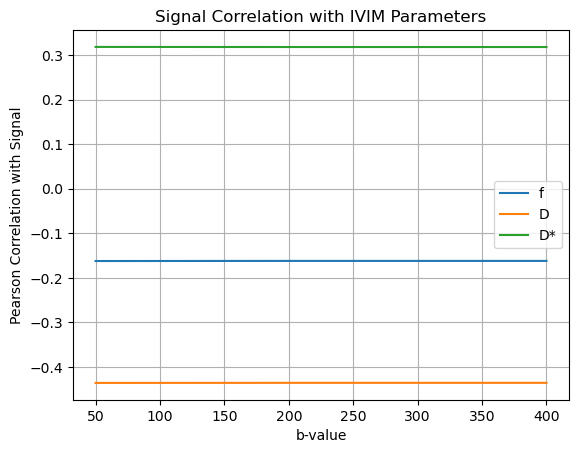

In [26]:
import matplotlib.pyplot as plt

plt.plot(df_corr['b-value'], df_corr['corr_f'], label='f')
plt.plot(df_corr['b-value'], df_corr['corr_D'], label='D')
plt.plot(df_corr['b-value'], df_corr['corr_D_star'], label='D*')
plt.xlabel("b-value")
plt.ylabel("Pearson Correlation with Signal")
plt.title("Signal Correlation with IVIM Parameters")
plt.legend()
plt.grid(True)
plt.show()
